In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage

skimage.__version__

'0.15.0'

In [2]:
img = "/Users/kunal/Documents/Cardetection/RecognizeLisencePlate/demo/plates/GEORGIA.jpg"

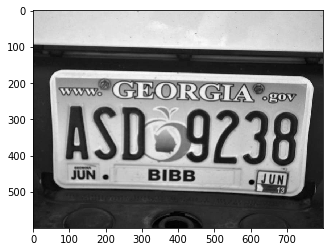

In [3]:
plate = skimage.io.imread(img, as_gray=True)
plt.imshow(plate, cmap='gray')

C:\Users\kunal\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


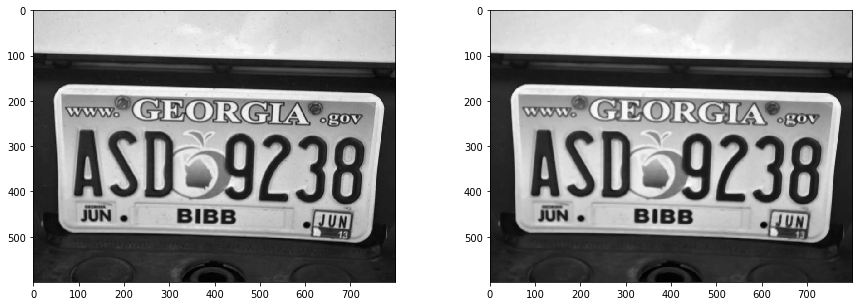

In [4]:
from skimage import filters

plate_denoised = filters.median(plate, selem=np.ones((5,5)))
f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(plate, cmap='gray')
ax1.imshow(plate_denoised, cmap='gray')

In [5]:
import os
os.chdir('/Users/kunal/Documents/Cardetection/')

In [25]:
from PIL import Image
import numpy

def fig2img ( fig ):
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )
 
def fig2data ( fig ):
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = numpy.fromstring ( fig.canvas.tostring_argb(), dtype=numpy.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = numpy.roll ( buf, 3, axis = 2 )
    return buf

In [26]:
im = fig2img (fig)
im.show()

C:\Users\kunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


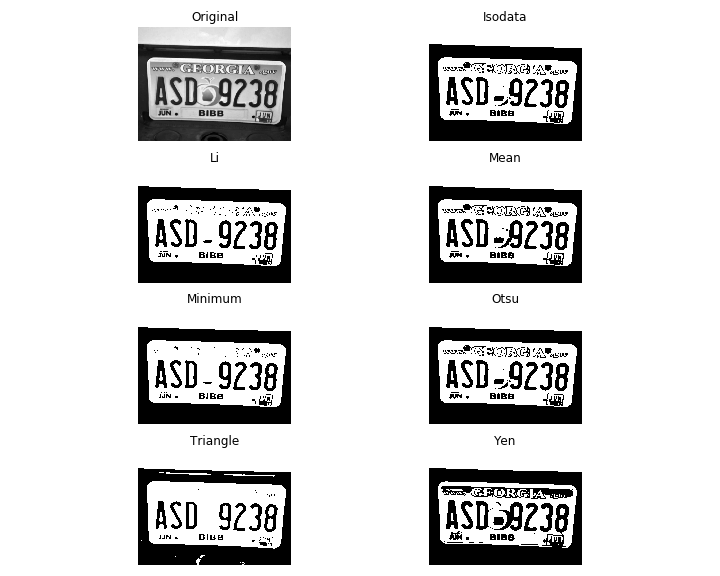

In [27]:
im

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


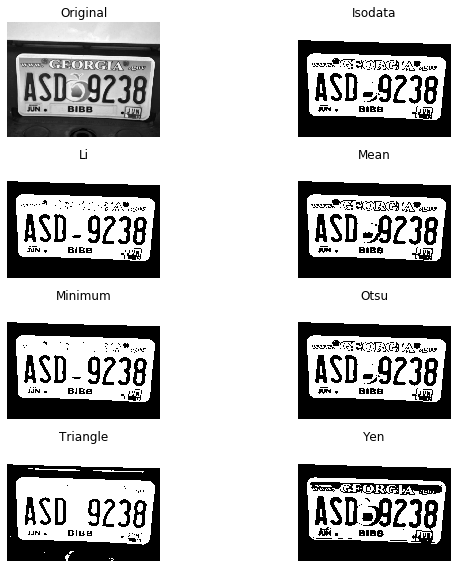

<Figure size 432x288 with 0 Axes>

In [6]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(plate_denoised, figsize=(10, 8), verbose=True)
plt.show()
plt.savefig ("test.png")


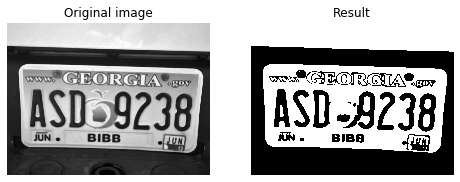

In [7]:
from skimage.filters import threshold_mean, threshold_otsu


thresh = threshold_mean(plate_denoised)
binary = plate_denoised > thresh
otsu = threshold_otsu(plate_denoised)
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(plate_denoised, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()




In [10]:
cv2.imshow(binary, cmap=plt.cm.gray)

TypeError: imshow() missing required argument 'mat' (pos 2)

In [8]:
import cv2

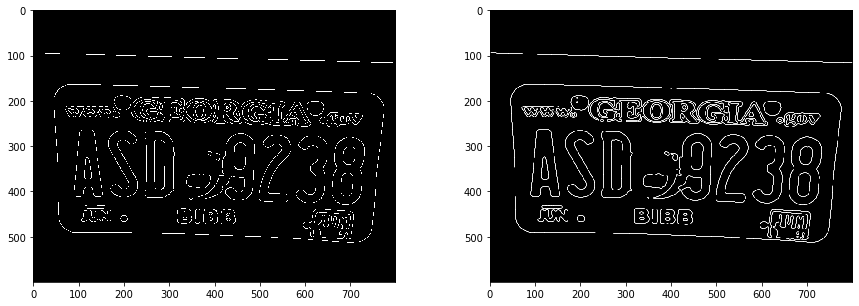

In [9]:
from skimage import feature, filters

edges = skimage.feature.canny(binary, sigma=3)
sobel_edges = skimage.filters.sobel(binary)

f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(edges, cmap='gray')
ax1.imshow(sobel_edges, cmap='gray')

Text(0.5, 1.0, 'Euclidian distance')

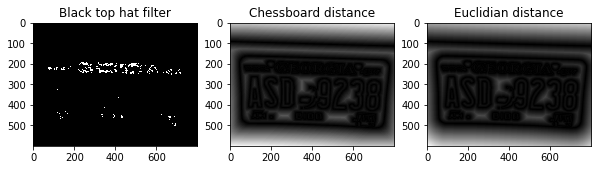

In [10]:
# euclidian distance, chessboard distance and city block (manhattan) distance

from scipy.ndimage import distance_transform_edt, distance_transform_cdt # euclidian distance - distance to closest background pixel
from scipy.ndimage.morphology import black_tophat

euclidian = distance_transform_edt(~edges)
dt = distance_transform_cdt(~edges, metric='chessboard')     # call on negative of edges
blackTopHat = black_tophat(edges, size=(5,5))               # black top hat filter         

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))

ax[0].imshow(blackTopHat, cmap='gray')
ax[0].set_title('Black top hat filter')
ax[1].imshow(dt, cmap='gray')
ax[1].set_title('Chessboard distance')
ax[2].imshow(euclidian, cmap='gray')
ax[2].set_title('Euclidian distance')

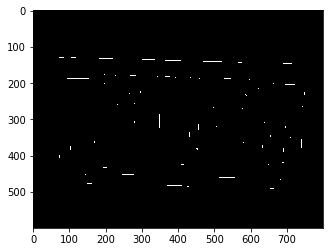

In [11]:
local_max = feature.peak_local_max(dt, indices=False, min_distance=20)
plt.imshow(local_max, cmap='gray')

In [12]:
peak_idx = feature.peak_local_max(dt, indices=True, min_distance=10)
peak_idx[:5]

array([[501, 626],
       [501, 625],
       [500, 626],
       [500, 625],
       [499, 626]], dtype=int64)

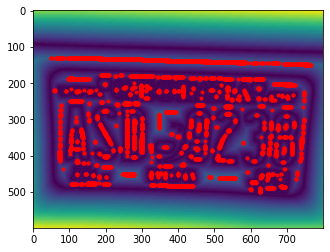

In [13]:
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')
plt.imshow(dt)

In [14]:
from skimage import measure

markers = measure.label(local_max)

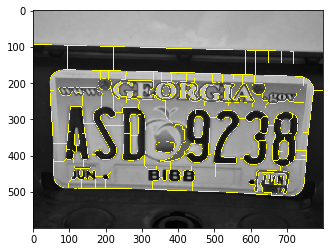

In [15]:
from skimage import morphology, segmentation

labels = morphology.watershed(-dt, markers)     # center of plate becomes trough
plt.imshow(segmentation.mark_boundaries(plate_denoised, labels))

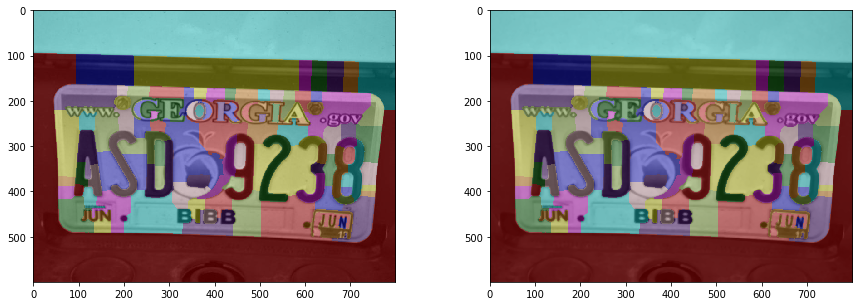

In [16]:
from skimage import color

f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(color.label2rgb(labels, image=plate))
ax1.imshow(color.label2rgb(labels, image=plate_denoised))

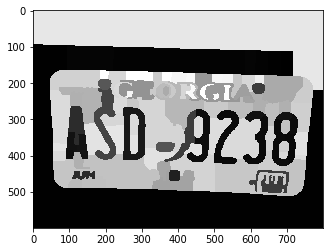

In [17]:
plt.imshow(color.label2rgb(labels, image=plate_denoised, kind='avg'), cmap='gray')


In [18]:
regions = measure.regionprops(labels, intensity_image=plate_denoised)      # list of region properties

(array([16.,  7.,  1.,  2.,  4.,  1.,  2.,  0.,  0.,  0.,  0.,  2.,  4.,
         7.,  7., 11., 16., 13.,  2., 12.]),
 array([ 28.4545051 ,  35.92914827,  43.40379144,  50.8784346 ,
         58.35307777,  65.82772093,  73.3023641 ,  80.77700727,
         88.25165043,  95.7262936 , 103.20093676, 110.67557993,
        118.15022309, 125.62486626, 133.09950943, 140.57415259,
        148.04879576, 155.52343892, 162.99808209, 170.47272526,
        177.94736842]),
 <a list of 20 Patch objects>)

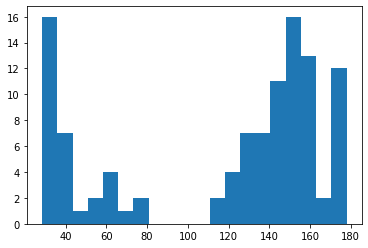

In [19]:
region_means = [r.mean_intensity for r in regions]
plt.hist(region_means, bins=20)

In [20]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2)

region_means = np.array(region_means).reshape(-1,1)

In [21]:
region_means

array([[ 29.90333855],
       [ 31.02116153],
       [ 30.64991134],
       [ 31.27105832],
       [ 30.63996627],
       [ 29.31042945],
       [ 28.4545051 ],
       [163.10455099],
       [177.91013384],
       [153.67780822],
       [177.03250774],
       [146.93877551],
       [176.42670537],
       [171.23394495],
       [173.73728814],
       [150.30093515],
       [116.95619048],
       [172.80377907],
       [171.02533333],
       [143.03650794],
       [153.63416739],
       [167.93162393],
       [ 79.43743428],
       [127.0142369 ],
       [114.14257717],
       [153.23296159],
       [ 64.45493562],
       [128.11229947],
       [138.52222222],
       [147.81560857],
       [177.94736842],
       [173.65714286],
       [121.50627615],
       [171.76717557],
       [176.59440559],
       [174.58369099],
       [124.79605263],
       [131.01977186],
       [ 68.69130139],
       [132.12640872],
       [145.20099875],
       [155.13867488],
       [156.4155496 ],
       [130

In [22]:
model.fit(region_means)
print(model.cluster_centers_)

[[150.46297317]
 [ 43.6348022 ]]


In [23]:
bg_fg_labels = model.predict(region_means)
bg_fg_labels

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [24]:
classified_labels = labels.copy()
for bg_fg, region in zip(bg_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bg_fg

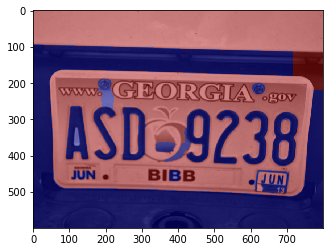

In [25]:
plt.imshow(color.label2rgb(classified_labels, image=plate))

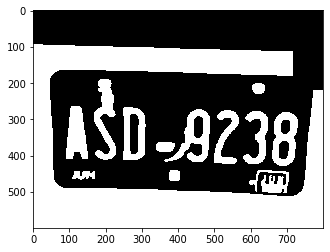

In [26]:
plt.imshow(classified_labels, cmap='gray')

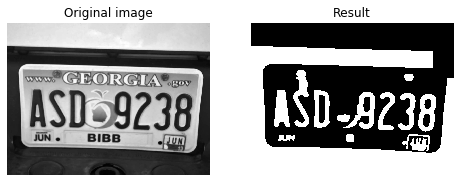

In [27]:
# Another thresholding
from skimage.filters import threshold_mean


thresh = threshold_mean(classified_labels)
binary = classified_labels > thresh

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(plate_denoised, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(classified_labels, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()